# Task 3.4 Construct Basic Quantum Circuits

**Overview:** This notebook covers how to construct quantum circuits.

* **Quantum circuit architecture** and Qiskit circuit object hierarchy and components
* **Custom circuit elements** and how to create user-defined gates and instructions
* **Circuit compilation** and how to convert abstract circuits to physical circuits
* **Circuit simulation** and some erorr suppression techniques

In [1]:
# Setup: Import necessary libraries
import numpy as np
import math
from qiskit.circuit import Gate, QuantumCircuit, Parameter,CircuitInstruction,SessionEquivalenceLibrary
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit.circuit import pauli_twirl_2q_gates
from qiskit.quantum_info import Statevector
from qiskit.providers.basic_provider import BasicProvider
from qiskit import transpile
from qiskit.circuit.classical import expr
from qiskit.circuit import get_control_flow_name_mapping
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator


print("Libraries imported successfully.")

Libraries imported successfully.


## Objective 1 : Quantum Circuit Fundamentals

In Qiskit, there are two main types of circuits:

- **Abstract circuit** : defined in terms of virtual qubits and arbitrary high-level operations, like encapsulated algorithms and user-defined gates. They are hardware-agnostic and focus on algorithmic logic.
- **Physical circuit**: defined in terms of the hardware qubits of one particular backend, it contains only operations that this backend natively supports. Also known as **ISA** (Instruction Set Architecture) circuits.

### Quantum Circuit API Overview

The Qiskit circuit hierarchy:

- **Bit** : can be a `Qubit`, a `Clbit` or an `AncillaQubit`.
- **Register** : a collection of bits, it can be a `QuantumRegister`, a `ClassicalRegister`or an `AncillaRegister`.
- **CircuitInstruction** : is composed of an `Operation` and its operands `Qubit`or `Clbit`.
- **Operation** : can be an `Instruction` which is hardware based instruction, a `Gate` which is a unitary instruction or a `ControlledGate` which is a gate with control structure.
- **Instruction** : can be a `Barrier`, a `Delay`, a `Measure`, a `Reset`, a `Store` or a `ControlFlowOp`.
- **ControlFlowOp** : can be a `BreakLoopOp`, a `ContinueLoopOp`, a `BoxOp`, a `ForLoopOp`, an `IfElseOp`, a `SwitchCaseOp`or a `WhileLoopOp`.

Circuits can include classical expressions evaluated in real time:

- **Var**: a typed classical storage location in a circuit.
- **Expr**: a real-time-evaluated expression.
- **Type**: classical type of an expression.

Additionally it includes Parameterization classes previously explained in previous notebooks:

- **Parameter**: the atom of compile-time expressions.
- **ParameterExpression**: a symbolic calculation on parameters.
- **ParameterVector**: a convenience collection of many Parameters.
- **ParameterVectorElement**: a subclass of Parameter used by ParameterVector.

There are also some classes that assist in compilation workflows like:
- **EquivalenceLibrary** : a database of decomposition relations between gates and circuits.
- **SessionEquivalenceLibrary** : a mutable instace of `EquivalenceLibrary`.

There is also `CircuitError` exception class and utility functions generating random circuits:

-`random.random_circuit()` <br/>
-`random.random_circuit_from_graph()` <br/>
-`random.random_clifford_circuit()`


In [2]:
# Custom Gate Example 
class EntanglmentGate(Gate):
    def __init__(self):
        # Initialize with name, number of qubits and parameters.
        super().__init__("ent", 2, [])
 
    def _define(self):
        #base definition is an h gate then cx.
        defn = QuantumCircuit(2)
        defn.h(0)
        defn.cx(0,1)
        self._definition = defn

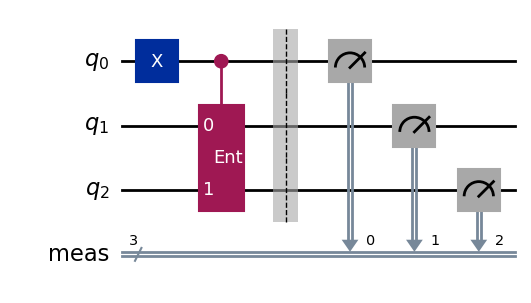

In [3]:
# Example 1:  Gate with control qubit
num_qubits=3
gate = EntanglmentGate()
qc= QuantumCircuit(num_qubits)
# add control to gate from qubit 0
qc.x(0)
gate = gate.control(1)
qc.append(gate,range(num_qubits),[])
qc.measure_all()
qc.draw('mpl')


Measurement Output: {'111': 494, '001': 506}


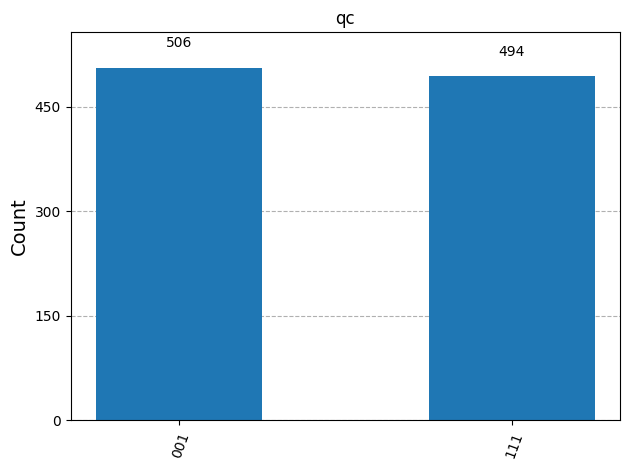

In [4]:
sim_ideal = AerSimulator()
result = sim_ideal.run(transpile(qc , sim_ideal),shots=1000).result()
#print(result)
counts = result.get_counts(0)
print("Measurement Output:", counts)
plot_histogram(counts, title='qc')


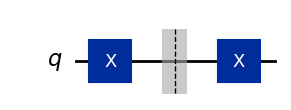

In [5]:
#Example 2: Using barrier in a quantum circuit
# compiler will not optimize across the barrier
qc = QuantumCircuit(1)
qc.x(0)
qc.barrier()
qc.x(0)
qc.draw('mpl')

In [6]:
# Example 3: Getting control flow name mapping
ctrl_flow_name_map = get_control_flow_name_mapping()
print(ctrl_flow_name_map)

{'if_else': <class 'qiskit.circuit.controlflow.if_else.IfElseOp'>, 'while_loop': <class 'qiskit.circuit.controlflow.while_loop.WhileLoopOp'>, 'for_loop': <class 'qiskit.circuit.controlflow.for_loop.ForLoopOp'>, 'switch_case': <class 'qiskit.circuit.controlflow.switch_case.SwitchCaseOp'>, 'box': <class 'qiskit.circuit.controlflow.box.BoxOp'>}


Advanced circuit with control flow and dynamic timing:


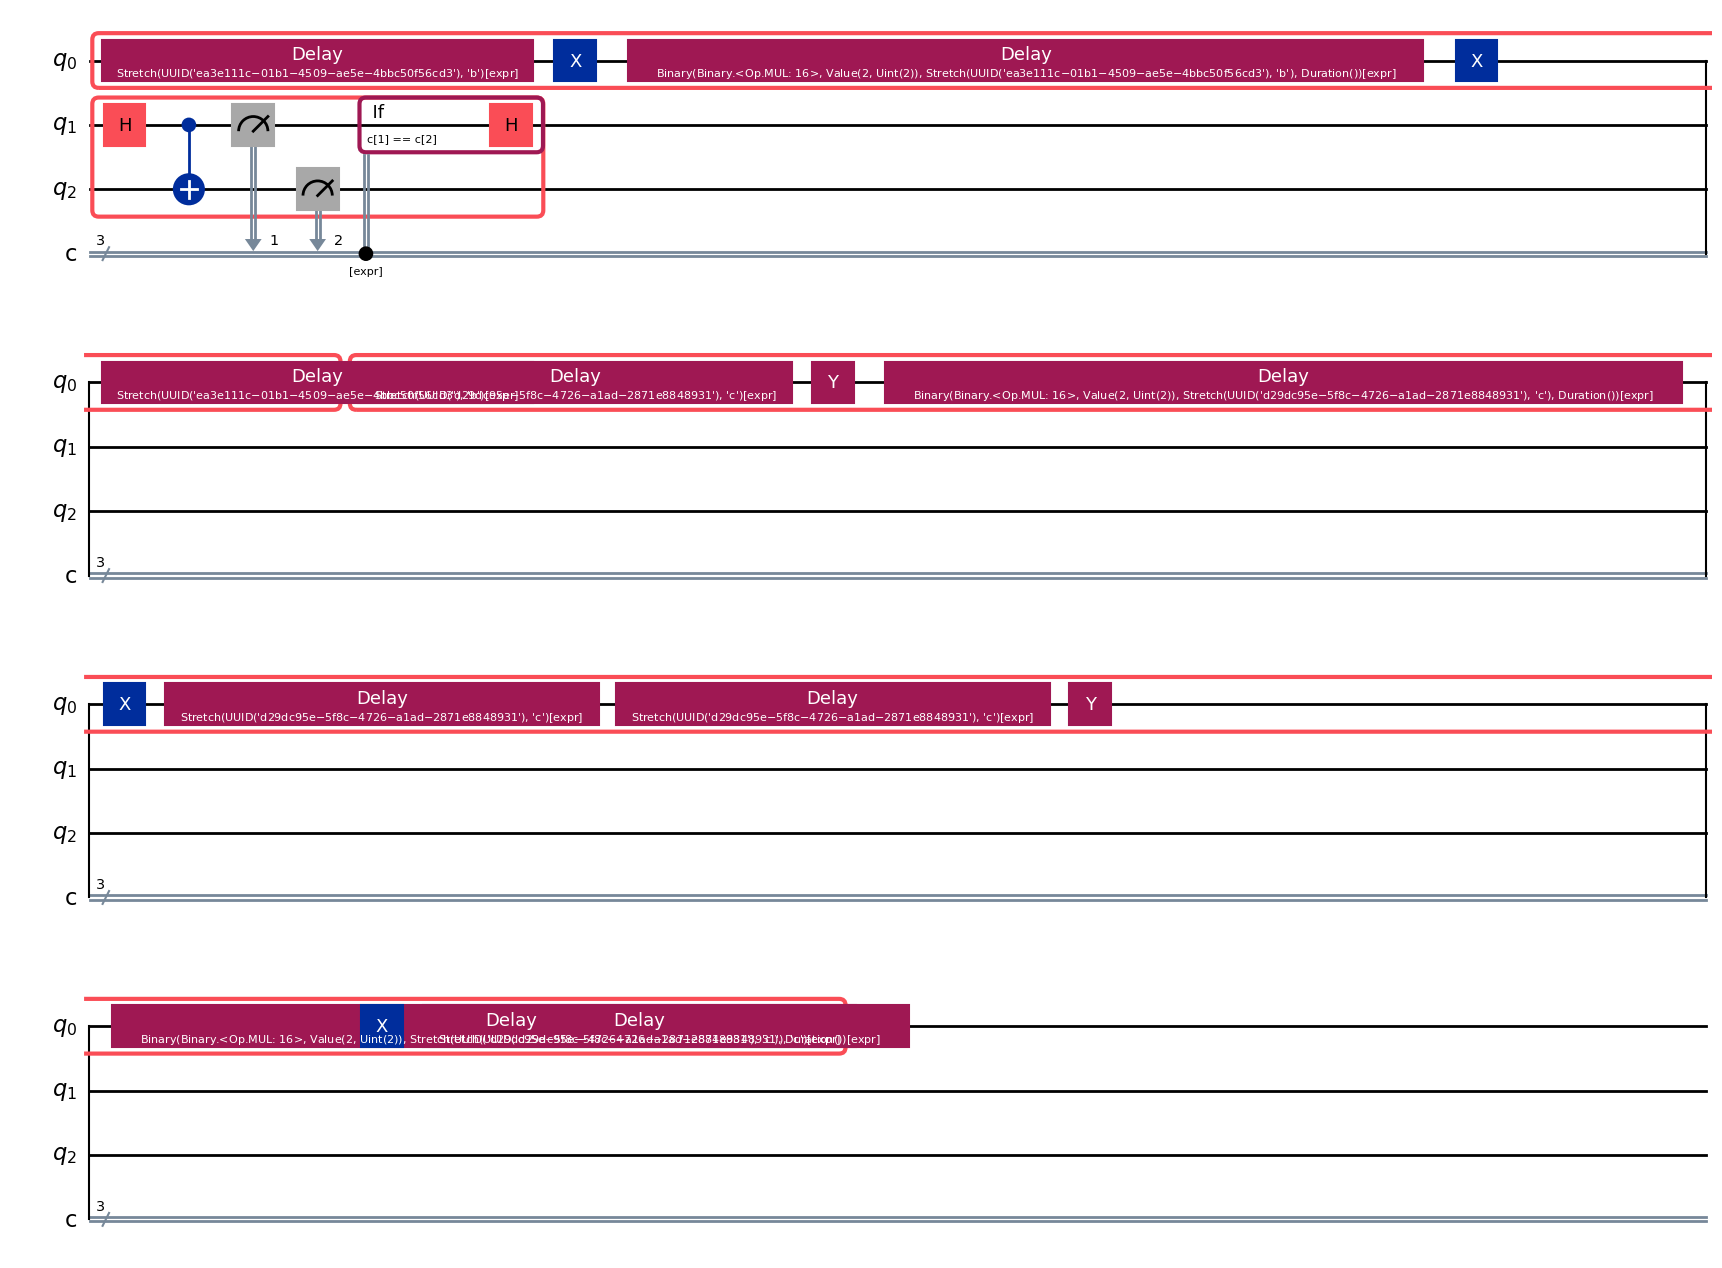

In [7]:
# Example 4: Using stretchable delays and control flow
qc = QuantumCircuit(3, 3)
# This sets up three duration "degrees of freedom" that will
# be resolved later by a backend compiler.
a = qc.add_stretch("a")
b = qc.add_stretch("b")
c = qc.add_stretch("c")
 
# This set of operations involves feed-forward operations that
# Qiskit cannot know the length of.
with qc.box():
    qc.h(1)
    qc.cx(1, 2)
    qc.measure([1, 2], [1, 2])
    with qc.if_test(expr.equal(qc.clbits[1], qc.clbits[2])):
        qc.h(1)
 
# While that stuff is happening to qubits (1, 2), we want
# qubit 0 to do two different DD sequences.  The two DD
# sequences are fixed to be the same length as each other,
# even though they're both internally stretchy.
with qc.box(duration=a):
    # Textbook NMRish XX DD.
    qc.delay(b, 0)
    qc.x(0)
    qc.delay(expr.mul(2, b), 0)
    qc.x(0)
    qc.delay(b, 0)
with qc.box(duration=a):
    # XY4-like DD.
    for _ in range(2):
        qc.delay(c, 0)
        qc.y(0)
        qc.delay(expr.mul(2, c), 0)
        qc.x(0)
        qc.delay(c, 0)
print("Advanced circuit with control flow and dynamic timing:")
qc.draw('mpl')

### Creating Instruction SubClasses

The easiest way to create a custom instruction or gate is simply to build its definition as a QuantumCircuit, and then use its `to_instruction()` or `to_gate()` , The results can be given directly to `QuantumCircuit.append()` on the larger circuit. 

For more complicated instructions or if it is goint to be used extensivly, custom gates or insturctions can be created.

Base Classes `Instruction` , `Gate` and `ControlledGate` can be subclassed, `_define()` method should be overridden to provide the circuit implementation for the instruction or gate. Other methods like `inverse()`, `control()` or `power()` can be overridden if there is an efficient optimization for them.

In [8]:
# Example  Custom Two-Qubit Gate Definition
class RXZGate(Gate):
    """A custom two-qubit gate implementing an RZX-like operation."""
    
    def __init__(self, theta):
        # Initialize with our name, number of qubits and parameters.
        super().__init__("rxz", 2, [theta])
 
    def _define(self):
        # base definition is an RZXGate, applied "backwards".
        defn = QuantumCircuit(2)
        defn.rzx(self.params[0], 1, 0)  # Note: qubit order swapped
        self._definition = defn
 
    def inverse(self, annotated=False):
        # We have an efficient representation of our inverse,
        # so we'll override this method.
        return RXZGate(-self.params[0])
 
    def power(self, exponent: float):
        # Also we have an efficient representation of power.
        return RXZGate(exponent * self.params[0])
 
    def __array__(self, dtype=None, copy=None):
        if copy is False:
            raise ValueError("unable to avoid copy while creating an array as requested")
        cos = math.cos(0.5 * self.params[0])
        isin = 1j * math.sin(0.5 * self.params[0])
        return np.array([
            [cos, -isin, 0, 0],
            [-isin, cos, 0, 0],
            [0, 0, cos, isin],
            [0, 0, isin, cos],
        ], dtype=dtype)

# Test the custom gate
theta = Parameter("theta")
custom_gate = RXZGate(theta)
print("Custom RXZGate created successfully!")
print(f"Gate name: {custom_gate.name}")
print(f"Number of qubits: {custom_gate.num_qubits}")
print(f"Parameters: {custom_gate.params}")

Custom RXZGate created successfully!
Gate name: rxz
Number of qubits: 2
Parameters: [Parameter(theta)]


You can add an equivalence for this gate to enable faster decomposition for it during translation stage. 

In [9]:
theta = Parameter("theta")
 
equiv = QuantumCircuit(2)
equiv.h(0)
equiv.cx(1, 0)
equiv.rz(theta, 0)
equiv.cx(1, 0)
equiv.h(0)
 
SessionEquivalenceLibrary.add_equivalence(RXZGate(theta), equiv)

### Converting abstract Circtuits to physical Circuits

Before running on real hardware , Abstract circuits are compiled to physical circuits using **transpile()** or **generate_preset_pass_manager()**.

In [10]:
# Example : Transpiling Abstract Circuit to Physical Circuit
# Create a complex abstract circuit
abstract_qc = QuantumCircuit(3)
abstract_qc.append(RXZGate(1.5), [0, 1])  # Using custom gate from previous example

print("Original circuit:")
print(abstract_qc)

# Use a fake backend for demonstration
backend = FakeTorino()

# Transpile to physical circuit
physical_qc = transpile(abstract_qc, backend=backend, optimization_level=1)

print("\nTranspiled circuit:")
print(physical_qc)

Original circuit:
     ┌───────────┐
q_0: ┤0          ├
     │  Rxz(1.5) │
q_1: ┤1          ├
     └───────────┘
q_2: ─────────────
                  

Transpiled circuit:
global phase: 3π/2
            ┌─────────┐┌────┐┌─────────────┐┌────┐┌─────────┐   
q_0 -> 0 ─■─┤ Rz(π/2) ├┤ √X ├┤ Rz(-1.6416) ├┤ √X ├┤ Rz(π/2) ├─■─
          │ └─────────┘└────┘└─────────────┘└────┘└─────────┘ │ 
q_1 -> 1 ─■───────────────────────────────────────────────────■─
                                                                


### Simulating Circuits

There are different ways to simulate circuits without running on real hardware:

- **BasicProvider**: Simple local simulator.
- **StateVectorSimulator**: Exact statevector simulation.
- **qiskit_aer**: High-performance simulator with noise models.
- **StateVectorSampler**: For sampling from statevector qiskit primitives implementation.
- **StateVectorEstimator**: For expectation value calculations qiskit primitives implementation.

In [11]:
# Create a simple circuit for simulation
sim_qc = QuantumCircuit(1)
sim_qc.h(0)

# Method 1: Statevector simulation
statevector = Statevector(sim_qc)

sim_qc.measure_all()


# Method 2: Aer simulator
aer_simulator = AerSimulator()
compiled_qc = transpile(sim_qc, aer_simulator)
result = aer_simulator.run(compiled_qc, shots=1024).result()
aer_counts = result.get_counts()



print("Simulation results:")
print(f"Counts: {aer_counts}")
print(f"Statevector: {statevector}")

Simulation results:
Counts: {'0': 489, '1': 535}
Statevector: Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


### Apply Pauli twirling to a circuit

Quantum error suppression technique that uses randomization to shape coherent error into stochastic errors, it applies random Pauli gates before and after operations, then combines results from many logically equivalent circuits.

Qiskit has function `pauli_twirl_2q_gates` that can be used to apply pauli twirling around specific two qubit gates.

In [12]:
# Create a circuit with two-qubit gates
qc = QuantumCircuit(3, 3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.rz(np.pi/4, 0)
qc.cx(0, 1)  # This might cancel with the first CX
qc.cx(1, 2)
qc.measure([0, 1, 2], [0, 1, 2])

print("Original circuit:")
print(qc)
print(f"Original circuit depth: {qc.depth()}")
print(f"Original circuit operations: {qc.count_ops()}")

# Apply Pauli twirling to two-qubit gates
print("\nApplying Pauli twirling to two-qubit gates...")

# Method 1: Create a single twirled circuit
twirled_circuit = pauli_twirl_2q_gates(qc, seed=42)
print("\nSingle twirled circuit:")
print(twirled_circuit)
print(f"Twirled circuit depth: {twirled_circuit.depth()}")
print(f"Twirled circuit operations: {twirled_circuit.count_ops()}")

Original circuit:
     ┌───┐     ┌─────────┐          ┌─┐      
q_0: ┤ H ├──■──┤ Rz(π/4) ├──■───────┤M├──────
     └───┘┌─┴─┐└─────────┘┌─┴─┐     └╥┘┌─┐   
q_1: ─────┤ X ├─────■─────┤ X ├──■───╫─┤M├───
          └───┘   ┌─┴─┐   └───┘┌─┴─┐ ║ └╥┘┌─┐
q_2: ─────────────┤ X ├────────┤ X ├─╫──╫─┤M├
                  └───┘        └───┘ ║  ║ └╥┘
c: 3/════════════════════════════════╩══╩══╩═
                                     0  1  2 
Original circuit depth: 6
Original circuit operations: OrderedDict({'cx': 4, 'measure': 3, 'h': 1, 'rz': 1})

Applying Pauli twirling to two-qubit gates...

Single twirled circuit:
global phase: π
     ┌───┐┌───┐     ┌───┐┌─────────┐┌───┐               ┌───┐     ┌─┐          »
q_0: ┤ H ├┤ Z ├──■──┤ Z ├┤ Rz(π/4) ├┤ Z ├────────────■──┤ I ├─────┤M├──────────»
     ├───┤└───┘┌─┴─┐├───┤└──┬───┬──┘└───┘┌───┐┌───┐┌─┴─┐├───┤┌───┐└╥┘     ┌───┐»
q_1: ┤ X ├─────┤ X ├┤ X ├───┤ Y ├─────■──┤ X ├┤ Z ├┤ X ├┤ Z ├┤ Y ├─╫───■──┤ Y ├»
     ├───┤     └───┘└───┘   └───┘   ┌─┴─┐├───┤├

---
# Summary
---

In this notebook, we covered:

## Construct Dynamic Circuits:

1. **Qiskit's circuit library** is organized in a hierarchical structure like bits, registers,circuit instructions, operations, control flows, classical expressions and parmaters.
2. **Circuits can be** physical which are mapped to aa specific hardware or abstract which is hardware agnostic.
3. **Custom circuit components** can be created like user defined gates and custom instructions. 
4. **Simulation methods** includes using BasicProvider, StateVectorSimulator, Qiskit Aer, StateVectorSampler and StateVectorEstimator.


---

## Practice Questions

**1) What is the primary difference between an abstract circuit and a physical circuit in Qiskit?**

A) Abstract circuits use classical bits, while physical circuits only use quantum bits<br/>

B) Abstract circuits contain only basic gates, while physical circuits include custom gates<br/>

C) Abstract circuits can only be simulated, while physical circuits run on real hardware<br/>

D) Abstract circuits are hardware-agnostic with virtual qubits, while physical circuits are mapped to specific backend hardware<br/>

E) Abstract circuits are faster to execute, while physical circuits are slower<br/>


**Answer:**
<details> <br/>

D) Abstract circuits are hardware-agnostic with virtual qubits, while physical circuits are mapped to specific backend hardware<br/>
Abstract circuits are defined in terms of virtual qubits and high-level operations, while physical circuits (ISA circuits) are defined for specific hardware backends using only natively supported operations.
</details>

---

**2)What happens when this code is executed?**

`qr = QuantumRegister(3, "a")`

`qc1 = QuantumCircuit(qr)`

`qc1.x(0)`

`qc1.x(2)`

`qc2 = QuantumCircuit(3)`

`qc2.h(1)`

`qc3 = qc1.compose(qc2, qubits=[0,1,2], inplace=False)`

A) A circuit with only the operations of qc2 mapped to [0,1,2]. <br/>

B) A circuit where qubits are reordered according to the mapping, discarding qc1. <br/>

C) A circuit with instructions from qc1 applied first, then qc2 on the same physical qubits. <br/>

D) A circuit where the H gate overwrites the X gates due to qubit reuse. <br/>


**Answer:**
<details> <br/>

C) A circuit with instructions from qc1 applied first, then qc2 on the same physical qubits. <br/>

</details>

---

**3)Which Qiskit function would you use to apply Pauli twirling specifically to two-qubit gates in a circuit?**

A) pauli_twirl_2q_gates()

B) apply_pauli_twirl()

C) pauli_twirl()

D) twirl_two_qubit_gates()

E) randomize_pauli_gates()

**Answer:**
<details> <br/>

A) pauli_twirl_2q_gates()

pauli_twirl_2q_gates() function applies Pauli twirling to two-qubit gates in a circuit
</details>